## Imports para análise e limpeza dos dados

In [47]:
import pathlib
import pandas           as pd
import numpy            as np
import matplotlib.pylab as plt
import plotly.express   as px
import seaborn          as sns
from collections import Counter

## Imports para Machine Learning

In [48]:
# Pré-processamento e divisão para treino e testes
from sklearn                 import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Algoritmos para seleção do melhor modelo de ML
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Métricas para validação de cada modelo
from sklearn.metrics         import confusion_matrix, accuracy_score, mean_absolute_error, roc_curve, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from pycaret.classification import *

In [49]:
## Caminho para os arquivos

path = pathlib.Path().cwd() / 'files/bs140513_032310.csv'
# path = pathlib.Path() / 'fraud_test_data.csv'

In [50]:
## importando arquivos e fazendo o reconhecimento dos dados

fraud_df = pd.read_csv(path)
fraud_df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


### Características relevantes do dataset

Alguns dados estão transformados:
- Os passos se referem à datas, entre os anos de 2012 a 2013. Entretanto, não foram descritas as datas exatas para esse intervalo. De certo, os dados correspondem a transações de 6 meses.
- A idade também foi pré-processada, com as seguintes características:

    - 0 = <18 anos
    - 1 = 19-25 anos
    - 2 = 26-35 anos
    - 3 = 36-45 anos
    - 4 = 46-55 anos
    - 5 = 56-65 anos
    - 6 = >65 anos
    - U = desconhecido

### Análise Descritiva dos dados

In [51]:
fraud_df.describe()

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.900000,0.000000
75%,139.000000,42.540000,0.000000
max,179.000000,8329.960000,1.000000


In [52]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [53]:
fraud_df.columns

Index(['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant',
       'zipMerchant', 'category', 'amount', 'fraud'],
      dtype='object')

In [54]:
## Avaliando as variáveis de texto para compreender se há colunas com dados únicos, não sendo úteis para a montagem do modelo
fraud_df_text = fraud_df[['age', 'customer', 'gender', 'zipcodeOri', 'merchant', 'zipMerchant', 'category']]

for i in fraud_df_text.columns:
    print(f'A quantidade de dados únicos para a coluna {i} é: {fraud_df_text[i].nunique()}')


A quantidade de dados únicos para a coluna age é: 8
A quantidade de dados únicos para a coluna customer é: 4112
A quantidade de dados únicos para a coluna gender é: 4
A quantidade de dados únicos para a coluna zipcodeOri é: 1
A quantidade de dados únicos para a coluna merchant é: 50
A quantidade de dados únicos para a coluna zipMerchant é: 1
A quantidade de dados únicos para a coluna category é: 15


### Evidência na análise univariada

É importante citar que:
- Os dados apresentados não possuem linhas nulas, um bom indicativo para que possamos usar o dataset sem implicar em uma limpeza maior dos dados.
- Há duas colunas que poderão ser desconsidaradas, já que aprensentam 1 único valor, que não é útil para o modelo de aprendizado de máquina: zipcodeOri e zipMerchant. Entretanto, para o caso de haver uma maior diversificação de região, é interessante ler o conteúdo e considerar a coluna como uma feature.

In [55]:
# Eliminando os dados de zipcode, pois serão irrelevantes para nossa análise.

# fraud_df = fraud_df.drop(['zipcodeOri', 'zipMerchant'], axis=1)
fraud_df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


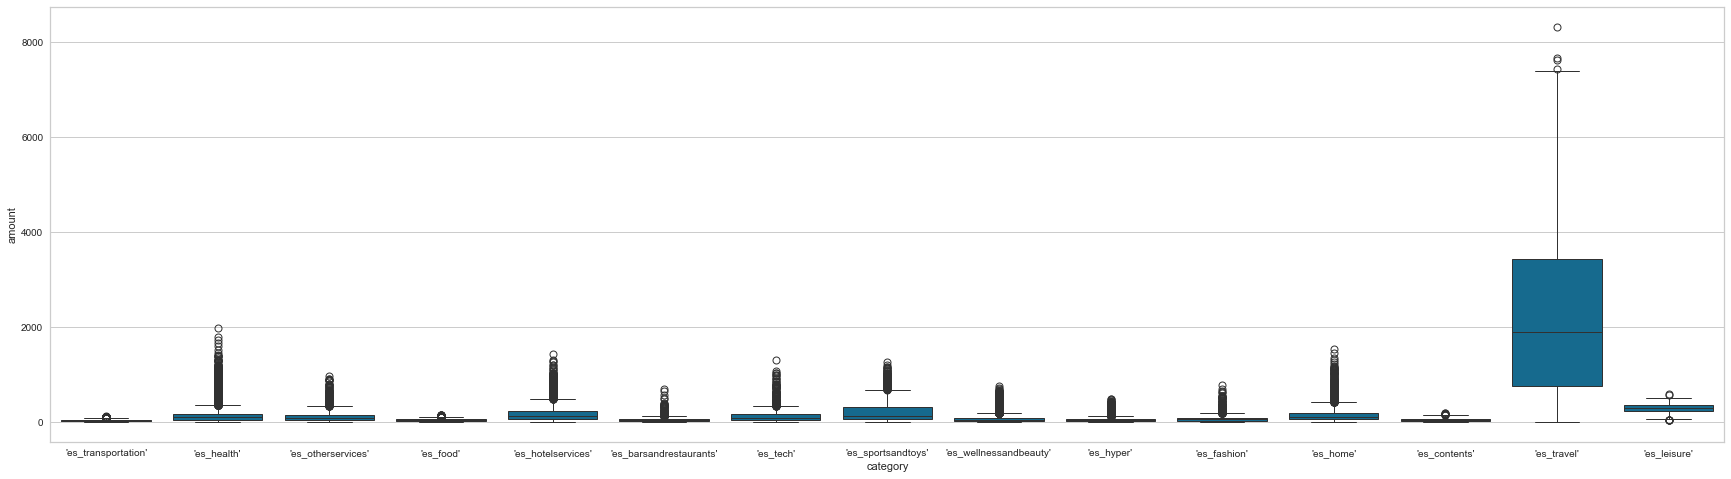

In [56]:
# Analisando as compras realizadas por cada categoria.

plt.subplots(figsize=(30,8))
sns.boxplot(data=fraud_df, x='category', y='amount')
plt.show()

Quantidade de casos de fraude: 7200


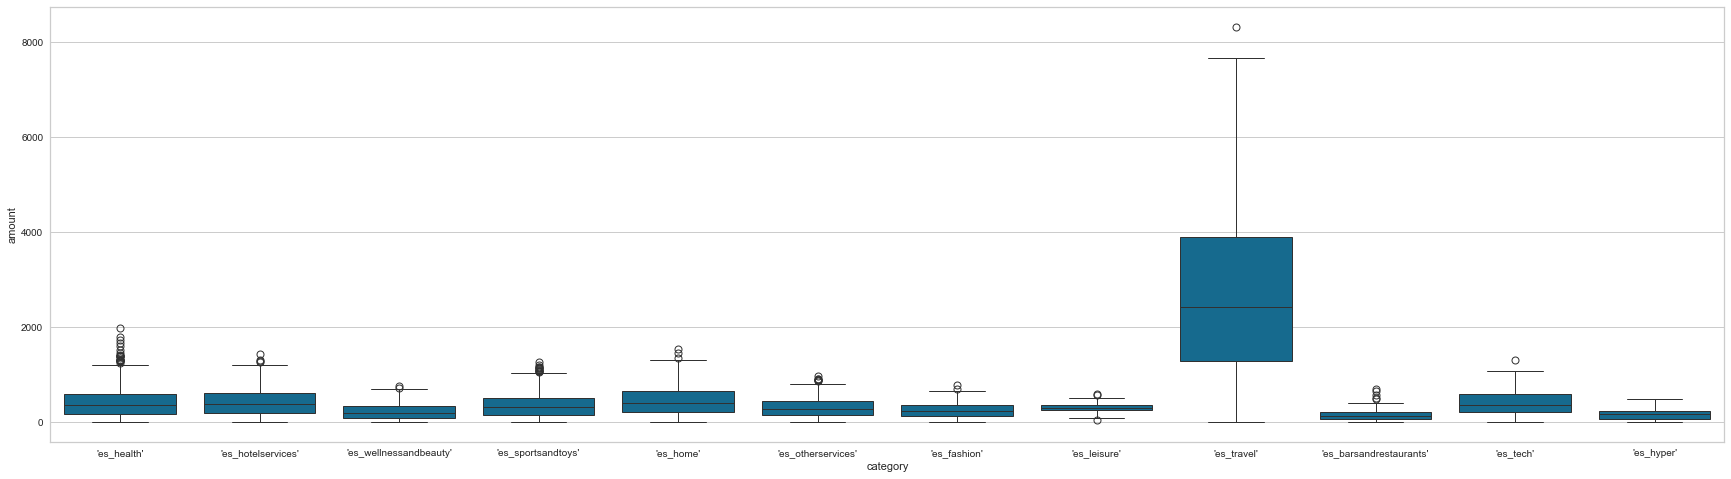

In [57]:
# Analisando as compras realizadas por cada categoria, agora verificando os casos onde houveram fraudes

cases = fraud_df.loc[fraud_df['fraud'] == 1].shape[0]
print(f'Quantidade de casos de fraude: {cases}')

plt.subplots(figsize=(30,8))
sns.boxplot(data=fraud_df.loc[fraud_df['fraud'] == 1], x='category', y='amount')
plt.show()

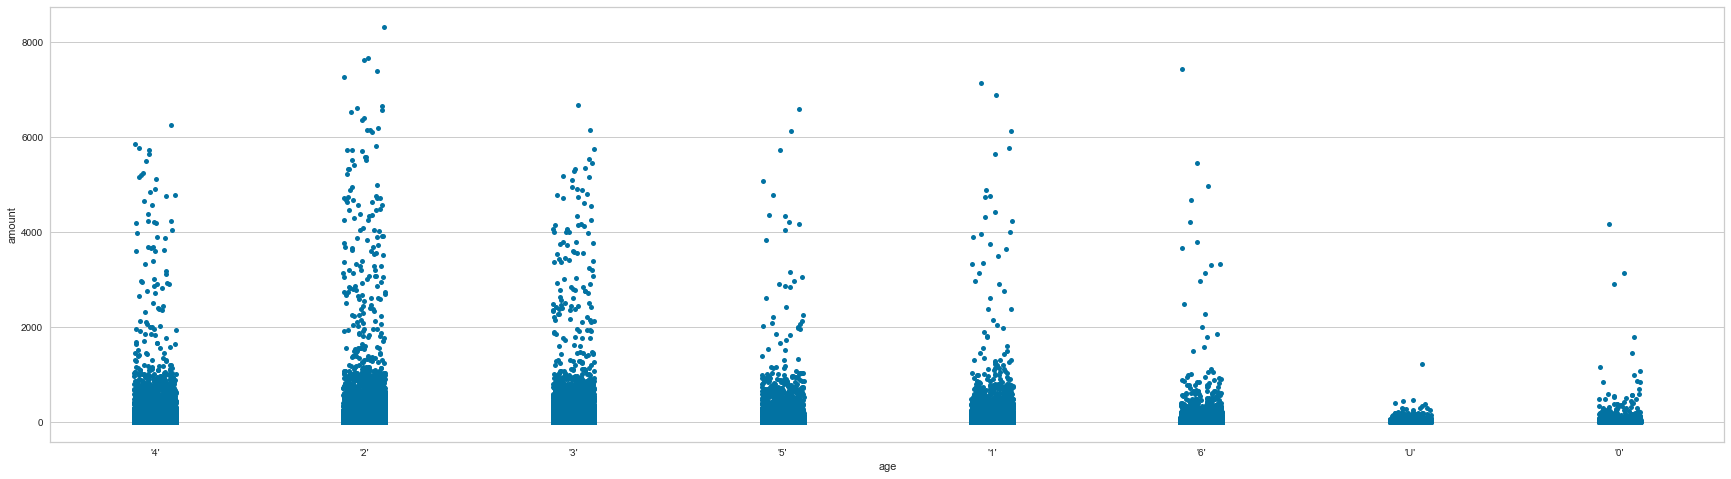

In [58]:
# Verificando o comportamento geral dos casos de compras, comparando valor x idade

order = ['0', '1', '2', '3', '4', '5', '6', 'U']

plt.subplots(figsize=(30,8))
sns.stripplot(data=fraud_df, x='age', y='amount')
plt.show()

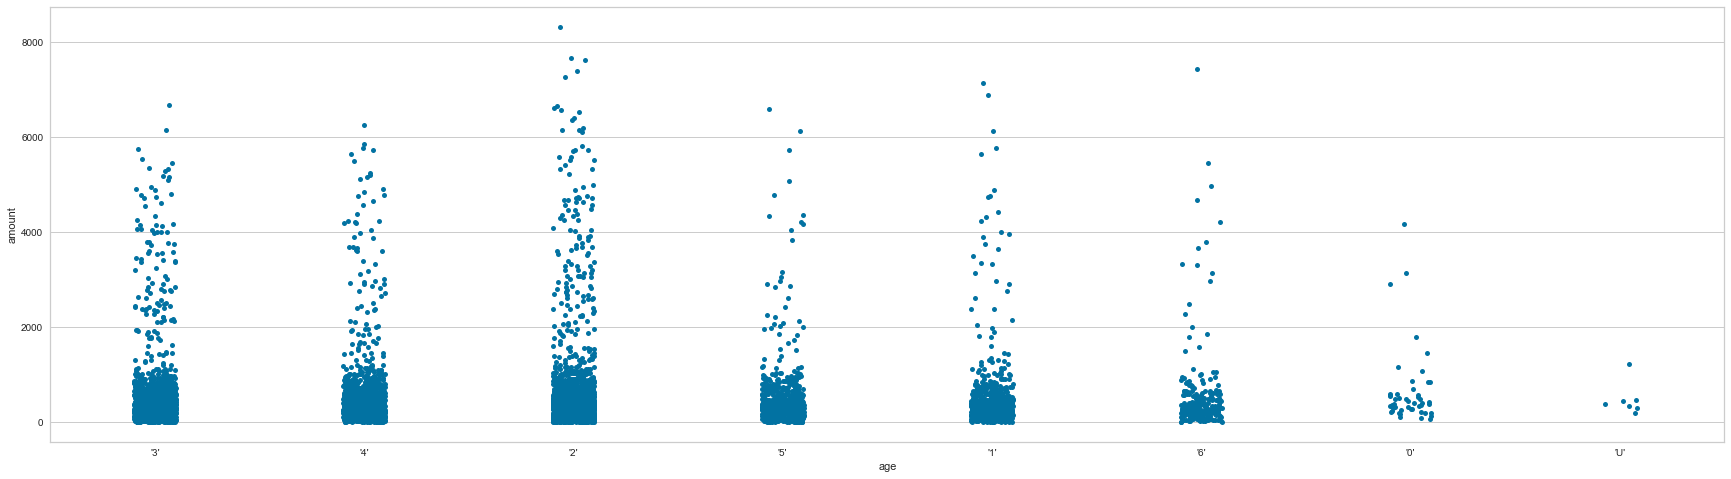

In [59]:
# Verificando o comportamento geral dos casos de compras, comparando valor x idade

cases = fraud_df.loc[fraud_df['fraud'] == 1]

plt.subplots(figsize=(30,8))
sns.stripplot(data=cases, x='age', y='amount')
plt.show()

In [60]:
# Verificando os maiores casos de fraude
cases['category'].value_counts()

'es_sportsandtoys'         1982
'es_health'                1696
'es_wellnessandbeauty'      718
'es_travel'                 578
'es_hotelservices'          548
'es_leisure'                474
'es_home'                   302
'es_hyper'                  280
'es_otherservices'          228
'es_tech'                   158
'es_barsandrestaurants'     120
'es_fashion'                116
Name: category, dtype: int64

In [61]:
cases['age'].value_counts()

'2'    2344
'3'    1755
'4'    1410
'1'     689
'5'     686
'6'     261
'0'      48
'U'       7
Name: age, dtype: int64

In [62]:
# Agora verificando casos que não foram capturados como fraude
not_cases = fraud_df.loc[fraud_df['fraud'] == 0]
not_cases['category'].value_counts()

'es_transportation'        505119
'es_food'                   26254
'es_health'                 14437
'es_wellnessandbeauty'      14368
'es_fashion'                 6338
'es_barsandrestaurants'      6253
'es_hyper'                   5818
'es_tech'                    2212
'es_sportsandtoys'           2020
'es_home'                    1684
'es_hotelservices'           1196
'es_contents'                 885
'es_otherservices'            684
'es_travel'                   150
'es_leisure'                   25
Name: category, dtype: int64

In [63]:
not_cases['age'].value_counts()

'2'    184966
'3'    145376
'4'    107615
'5'     61956
'1'     57442
'6'     26513
'0'      2404
'U'      1171
Name: age, dtype: int64

In [64]:
not_cases["amount"].value_counts().sort_values()

190.31      1
180.26      1
134.47      1
258.55      1
106.26      1
         ... 
17.26     143
16.12     143
17.57     144
14.93     146
26.67     146
Name: amount, Length: 18809, dtype: int64

### Anotações

Podemos notar que:
- Casos de fraude são mais comuns para o setor de brinquedos e esportes, dentro da faixa 2 de idade.
- Ainda assim, a faixa 2 também é responsável por boa parte das compras que não foram marcadas como fraude, embora haja uma mudança na categoria que mais registra casos "normais": transporte


# Pré-processamento dos dados

In [65]:
fraud_df.columns

Index(['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant',
       'zipMerchant', 'category', 'amount', 'fraud'],
      dtype='object')

In [66]:
# Definindo novos intervalos (bins) para rebalancear a distribuição
bins = [0, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 2000, 4000, 6000, 8000, 8400]
labels = ['0-20', '20-40', '40-60', '60-80', '80-100', '100-200', '200-400', '400-600', '600-800', '800-1000', '1000-2000', '2000-4000', '4000-6000', '6000-8000', '8000-8400']

# Criando uma nova coluna categorizada
fraud_df['amount_category'] = pd.cut(fraud_df['amount'], bins=bins, labels=labels, include_lowest=True)

# print(fraud_df['amount_category'].value_counts())

In [67]:
# Aqui estamos convertendo textos para registros numéricos, permitindo que o algoritmo de machine learning leia as colunas
label_encoder = preprocessing.LabelEncoder()
one_hot_encoder_gender = preprocessing.OneHotEncoder(sparse_output=False)
one_hot_encoder_category = preprocessing.OneHotEncoder(sparse_output=False)

columns_1 = ['customer', 'merchant', 'amount_category', 'zipcodeOri', 'zipMerchant']
columns_2 = ['gender', 'category']

# Pré-processamento final dos dados
fraud_ml = fraud_df.copy()
fraud_ml.replace("'", "", regex=True, inplace=True)
fraud_ml['age'].replace("U", "7", inplace=True)
fraud_ml['age'] = fraud_ml['age'].astype(int)

for i in columns_1:
    fraud_ml[i] = label_encoder.fit_transform(fraud_ml[i])

# Ajustando e transformando o OneHotEncoder no mesmo conjunto de dados
fraud_ml_gender = one_hot_encoder_gender.fit_transform(fraud_ml[['gender']])
fraud_ml_category = one_hot_encoder_category.fit_transform(fraud_ml[['category']])

# Obtendo os nomes das colunas corretamente
df_gender_encoded = pd.DataFrame(fraud_ml_gender, columns=one_hot_encoder_gender.get_feature_names_out(['gender']))
df_category_encoded = pd.DataFrame(fraud_ml_category, columns=one_hot_encoder_category.get_feature_names_out(['category']))

# Concatenando os resultados
fraud_ml = pd.concat([fraud_ml, df_gender_encoded, df_category_encoded], axis=1)

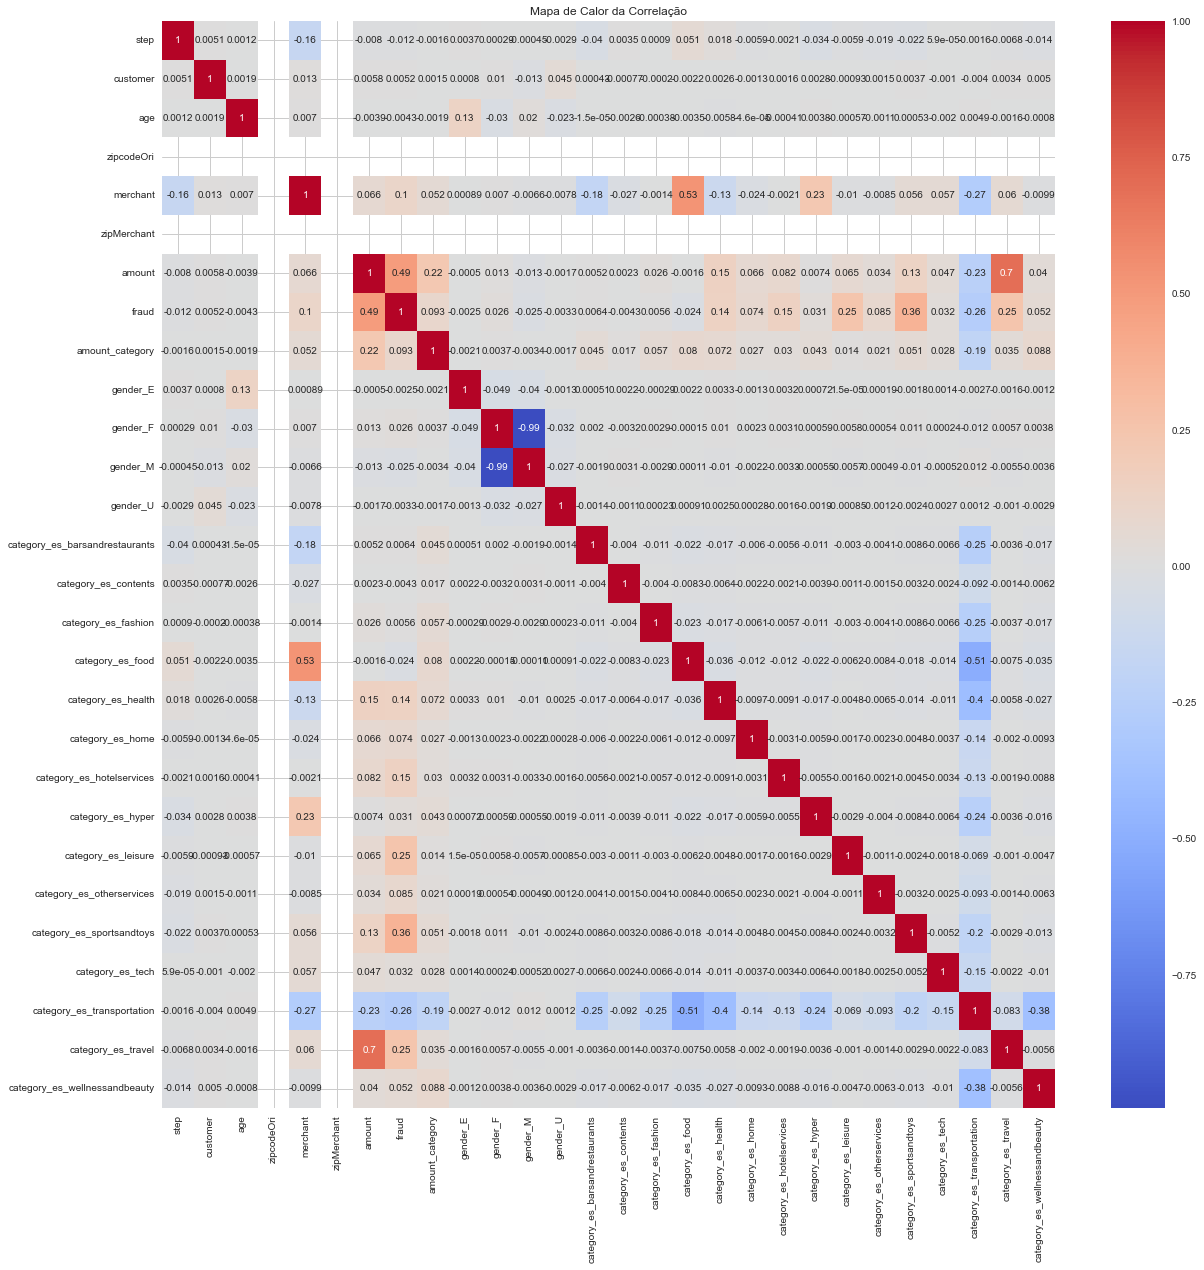

In [68]:
## Correlação dos dados

# Calculando a matriz de correlação
correlation_matrix = fraud_ml.corr()

# Criando um mapa de calor
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Mapa de Calor da Correlação')
plt.show()

In [69]:
# Removendo últimas colunas para montar o dataset que irá para treino

fraud_ml.drop(['step', 'gender', 'category'], axis=1, inplace=True)

In [70]:
# Supondo que você tenha um DataFrame chamado df com suas características (features) e a variável alvo (target)
# Substitua 'X' com suas características e 'y' com sua variável alvo
# x = fraud_ml.drop('fraud', axis=1)
# y = fraud_ml['fraud']

# # Mostra a distribuição original das classes
# print(f'Distribuição original das classes: {Counter(y)}')

# # Cria o objeto RandomUnderSampler
# rus = NearMiss()

# # Ajusta e transforma os dados
# X_resampled, y_resampled = rus.fit_resample(x, y)

# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(x, y)

# # Mostra a nova distribuição das classes
# print(f'Nova distribuição das classes: {Counter(y_resampled)}')

# # Converte de volta para DataFrame se necessário
# df_resampled = pd.DataFrame(X_resampled, columns=x.columns)
# df_resampled['target'] = y_resampled

# df_resampled.head()


In [71]:
# fraud_ml = df_resampled

fraud_ml_1 = fraud_ml.loc[fraud_ml['fraud'] == 0][:75001]
fraud_ml_2 = fraud_ml.loc[fraud_ml['fraud'] == 1]

fraud_ml = pd.concat([fraud_ml_1, fraud_ml_2], axis=0)

x = fraud_ml.drop(columns=['fraud'])
y = fraud_ml['fraud']

In [72]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state = 42, stratify=y)

In [73]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Montagem do pipeline para criação do algoritmo

In [74]:
## Com o uso do PyCaret, podemos avaliar quais são os melhores modelos dado nosso dataset.

# Configurar o PyCaret
clf = setup(fraud_ml, target='fraud')

# Comparar modelos
best_model = compare_models()

# Avaliar o melhor modelo
print(best_model)

,Description,Value
0,Session id,7106
1,Target,fraud
2,Target type,Binary
3,Original data shape,"(82201, 27)"
4,Transformed data shape,"(82201, 27)"
5,Transformed train set shape,"(57540, 27)"
6,Transformed test set shape,"(24661, 27)"
7,Numeric features,26
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9824,0.9961,0.8696,0.9248,0.8962,0.8866,0.8872,0.2510
xgboost,Extreme Gradient Boosting,0.9821,0.9961,0.8720,0.9202,0.8952,0.8855,0.8860,0.2930
gbc,Gradient Boosting Classifier,0.9796,0.9952,0.8423,0.9185,0.8786,0.8675,0.8685,2.0410
rf,Random Forest Classifier,0.9792,0.9920,0.8556,0.9016,0.8779,0.8665,0.8669,0.8210
et,Extra Trees Classifier,0.9785,0.9902,0.8591,0.8916,0.8749,0.8631,0.8634,0.6190
ada,Ada Boost Classifier,0.9761,0.9939,0.8075,0.9100,0.8555,0.8425,0.8445,0.7390
lr,Logistic Regression,0.9739,0.9918,0.7998,0.8921,0.8431,0.8290,0.8306,4.1270
dt,Decision Tree Classifier,0.9726,0.9169,0.8492,0.8403,0.8446,0.8296,0.8297,0.0900
knn,K Neighbors Classifier,0.9705,0.9362,0.7621,0.8859,0.8191,0.8032,0.8060,1.1450
ridge,Ridge Classifier,0.9618,0.9854,0.7679,0.7903,0.7787,0.7578,0.7580,0.0750


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=7106, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [75]:
# Definir o modelo LGBMClassifier com os hiperparâmetros fornecidos
from lightgbm import LGBMClassifier

model_auto_ml = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=6645, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

# Treinar o modelo
model_auto_ml.fit(x_train, y_train)

# Avaliar o modelo
y_pred = model_auto_ml.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {roc_auc}")

[LightGBM] [Info] Number of positive: 5040, number of negative: 52500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 57540, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087591 -> initscore=-2.343407
[LightGBM] [Info] Start training from score -2.343407
Acurácia: 0.9815092656421069
Precisão: 0.9152046783625731
Recall: 0.8694444444444445
F1-Score: 0.8917378917378918
AUC-ROC: 0.93085572739977


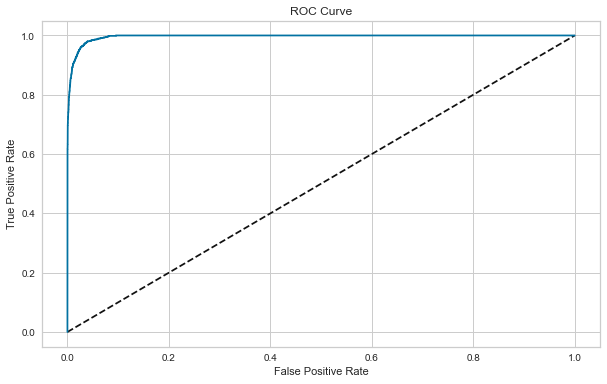

In [76]:
y_pred_prob = model_auto_ml.predict_proba(x_test)[:,1]

# Gera fpr, tpr e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# curva ROC
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [77]:
cv_scores = cross_val_score(model_auto_ml, x_train, y_train, cv=5, scoring='roc_auc')
print(f'Média de Resultados da validação cruzada: {cv_scores.mean()}')

[LightGBM] [Info] Number of positive: 4032, number of negative: 42000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 46032, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087591 -> initscore=-2.343407
[LightGBM] [Info] Start training from score -2.343407
[LightGBM] [Info] Number of positive: 4032, number of negative: 42000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 46032, number of used features: 24
[LightGBM] [Info] [bin

In [78]:
# Random Forest Classifier
rf = RandomForestClassifier(max_depth=5, min_samples_split=8, n_estimators=50, class_weight='balanced', random_state=42) 
model = rf.fit(x_train, y_train)

y_pred = model.predict(x_test)
# accuracy_score(y_test, y_pred)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {roc_auc}")

Acurácia: 0.9219009772515308
Precisão: 0.5290034705007437
Recall: 0.9879629629629629
F1-Score: 0.6890539231514369
AUC-ROC: 0.9517611357190708


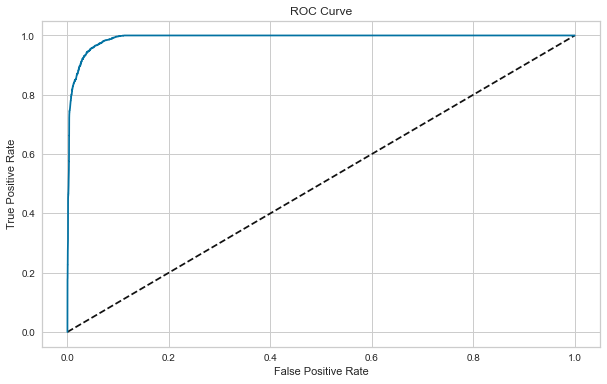

In [79]:
y_pred_prob = model.predict_proba(x_test)[:,1]

# Gera fpr, tpr e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# curva ROC
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [80]:
cv_scores = cross_val_score(model, x_test, y_test, cv=5, scoring='roc_auc')
cv_scores
# print(f'Média de Resultados da validação cruzada: {cv_scores.mean()}')

array([0.99303113, 0.99051955, 0.9922001 , 0.9911304 , 0.99178447])

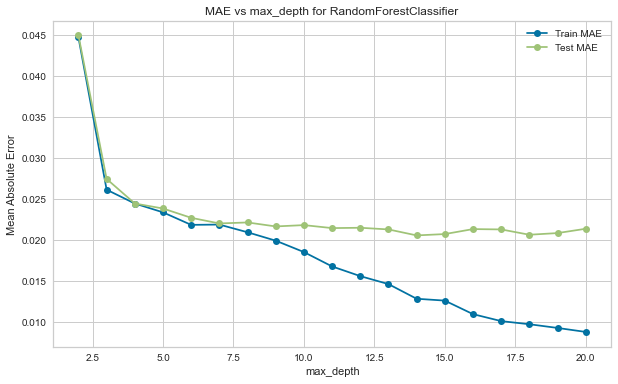

In [81]:
# Listas para armazenar os resultados
train_errors = []
test_errors = []
max_depths = range(2,21)

# Treinando e avaliando o modelo para diferentes valores de max_depth
for max_depth in max_depths:
    model = RandomForestClassifier(max_depth=max_depth, min_samples_split=6, n_estimators=20, random_state=42)
    model.fit(x_train, y_train)
    
    # Previsões no conjunto de treino e teste
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    # Calculando o MAE
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Armazenando os resultados
    train_errors.append(train_mae)
    test_errors.append(test_mae)

# Plotando os resultados
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_errors, label='Train MAE', marker='o')
plt.plot(max_depths, test_errors, label='Test MAE', marker='o')
plt.xlabel('max_depth')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs max_depth for RandomForestClassifier')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
# Testando agora com logistic regression
lr = LogisticRegression(C=100, penalty='l1', solver='saga')
model_2 = lr.fit(x_train, y_train)

y_pred = model_2.predict(x_test)
# accuracy_score(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {roc_auc}")

Acurácia: 0.9737236932808888
Precisão: 0.8818181818181818
Recall: 0.8083333333333333
F1-Score: 0.8434782608695652
AUC-ROC: 0.8989668977675067


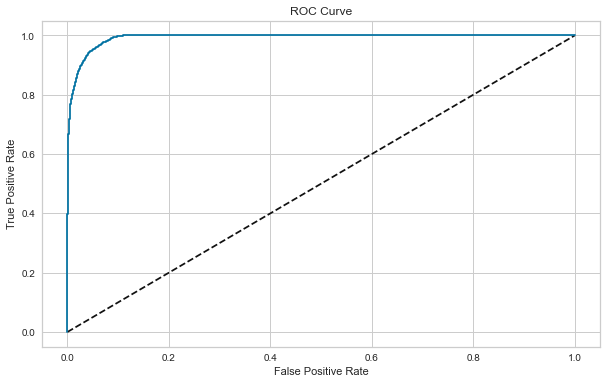

In [83]:
y_pred_prob = model_2.predict_proba(x_test)[:,1]

# Gera fpr, tpr e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# curva ROC
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [84]:
cv_scores = cross_val_score(model, x_test, y_test, cv=5, scoring='roc_auc')
print(f'Média de Resultados da validação cruzada: {cv_scores.mean()}')

Média de Resultados da validação cruzada: 0.9938335717920023


## Avaliação

Com o uso de dados desbalanceados, é esperado que haja um possível problema de overfitting para o uso dos dados após o treinamento do modelo.

Como veremos abaixo, o modelo que melhor se adaptou a esse problema foi o Random Forest Classifier.

In [85]:
# Função para gerar valores de amount com maior concentração entre 0 e 100
def generate_amount():
    if np.random.rand() < 0.8:  # 80% de chance de estar entre 0 e 100
        return np.round(np.random.uniform(0.1, 100), 2)
    else:  # 20% de chance de estar entre 100 e 8400
        return np.round(np.random.uniform(100, 8400), 2)

novo_exemplo = pd.DataFrame({
    'step': np.random.randint(1, 200, 500),
    'customer': [f'C{np.random.randint(100000000, 999999999)}' for _ in range(500)],
    'age': np.random.choice([0, 1, 2, 3, 4, 5, 6, 7], 500),
    'gender': np.random.choice(['M', 'F'], 500),
    'merchant': [f'M{np.random.randint(100000000, 999999999)}' for _ in range(500)],
    'category': np.random.choice([
        "es_transportation", "es_health", "es_otherservices", "es_food",
        "es_hotelservices", "es_barsandrestaurants", "es_tech",
        "es_sportsandtoys", "es_wellnessandbeauty", "es_hyper", "es_fashion",
        "es_home", "es_contents", "es_travel", "es_leisure"
    ], 500),
    'amount': [generate_amount() for _ in range(500)],
    'fraud': np.random.choice([0, 1], 500, p=[0.95, 0.05]),
    'zipcodeOri': '28007',
    'zipMerchant': '28007',
})

label_columns = ['customer', 'merchant', 'amount_category', 'zipcodeOri', 'zipMerchant']

columns_order = ['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant',
       'zipMerchant', 'category', 'amount', 'fraud']

novo_exemplo = novo_exemplo[columns_order]
# Definindo os intervalos (bins) e os rótulos (labels)
bins = [0, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 2000, 4000, 6000, 8000, 8400]
labels = ['0-20', '20-40', '40-60', '60-80', '80-100', '100-200', '200-400', '400-600', '600-800', '800-1000', '1000-2000', '2000-4000', '4000-6000', '6000-8000', '8000-8400']

# Criando a coluna categorizada
novo_exemplo['amount_category'] = pd.cut(novo_exemplo['amount'], bins=bins, labels=labels, include_lowest=True)

# Função para lidar com novos valores no LabelEncoder
def handle_new_labels(encoder, value):
    if value in encoder.classes_:
        return encoder.transform([value])[0]
    else:
        # Adiciona a nova classe temporariamente e transforma o valor
        new_classes = np.append(encoder.classes_, value)
        encoder.classes_ = new_classes
        encoder.fit(encoder.classes_)  # Reajusta o encoder para incluir a nova classe
        return encoder.transform([value])[0]

# Aplique o mesmo pré-processamento no novo exemplo
novo_exemplo['age'].replace("U", "7", inplace=True)
novo_exemplo['age'] = novo_exemplo['age'].astype(int)

# Aplicar LabelEncoder nas colunas categóricas com verificação de novos valores
for i in label_columns:
    novo_exemplo[i] = novo_exemplo[i].apply(lambda x: handle_new_labels(label_encoder, x))

# Aplicar OneHotEncoder nas colunas 'gender' e 'category'
novo_exemplo_gender = one_hot_encoder_gender.transform(novo_exemplo[['gender']])
novo_exemplo_category = one_hot_encoder_category.transform(novo_exemplo[['category']])

# Convertendo os resultados para DataFrame
df_novo_exemplo_gender = pd.DataFrame(novo_exemplo_gender, columns=one_hot_encoder_gender.get_feature_names_out(['gender']))
df_novo_exemplo_category = pd.DataFrame(novo_exemplo_category, columns=one_hot_encoder_category.get_feature_names_out(['category']))

# Concatenando as novas colunas com o novo exemplo
novo_exemplo = pd.concat([novo_exemplo, df_novo_exemplo_gender, df_novo_exemplo_category], axis=1)

y = novo_exemplo['fraud']

# Removendo colunas desnecessárias
novo_exemplo.drop(['gender', 'category', 'fraud', 'step'], axis=1, inplace=True)

# Aplicando o mesmo escalonamento de valores
novo_exemplo_scaled = scaler.transform(novo_exemplo)


In [86]:
# Realizando a previsão
y_pred_novo_exemplo = model.predict(novo_exemplo_scaled) # Random Forest

# print(f'Previsão para o novo exemplo: {y_pred_novo_exemplo}')
accuracy_score(y, y_pred_novo_exemplo)

0.63

In [87]:
# Realizando a previsão
y_pred_novo_exemplo_2 = model_auto_ml.predict(novo_exemplo_scaled) # LG Model
accuracy_score(y, y_pred_novo_exemplo_2)

0.202

In [88]:
# Realizando a previsão
y_pred_novo_exemplo_3 = model_2.predict(novo_exemplo_scaled) # Logistic Regression
accuracy_score(y, y_pred_novo_exemplo_3)

0.062